In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/DATA606 Capstone/Raw Data

Mounted at /content/drive
/content/drive/My Drive/DATA606 Capstone/Raw Data


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics 
from imblearn.over_sampling import SMOTE
import graphviz
from sklearn.tree import export_graphviz
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
plt.rcParams['figure.figsize'] = (10,8)

### Import data and prepare for modeling

In [3]:
# import data
df = pd.read_csv('crash_weather_2015-2019.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129145 entries, 0 to 129144
Data columns (total 80 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  129145 non-null  int64  
 1   X                           129145 non-null  float64
 2   Y                           129145 non-null  float64
 3   OBJECTID                    129145 non-null  int64  
 4   CRIMEID                     129145 non-null  int64  
 5   CCN                         129145 non-null  object 
 6   REPORTDATE                  129145 non-null  object 
 7   ROUTEID                     129145 non-null  object 
 8   MEASURE                     129145 non-null  float64
 9   OFFSET                      129145 non-null  float64
 10  STREETSEGID                 113667 non-null  float64
 11  ROADWAYSEGID                113667 non-null  float64
 12  FROMDATE                    129145 non-null  object 
 13  TODATE        

In [4]:
# filter out accidents that did not involve a car
df = df[df['TOTAL_VEHICLES'] > 0]

In [5]:
# update date variables to date type 
df['REPORTDATE'] = pd.to_datetime(df['REPORTDATE'], errors='coerce')
df = df.loc[(df['REPORTDATE'].dt.year > 2015) & (df['REPORTDATE'].dt.year < 2020)]

# extract year, month, hour and weekday
df['YEAR'] = df['REPORTDATE'].dt.year
df['MONTH'] = df['REPORTDATE'].dt.strftime('%b')
df['HOUR'] = df['REPORTDATE'].dt.hour
df['WEEKDAY'] = df['REPORTDATE'].dt.strftime('%a')

In [6]:
# set target and feature variables
targets = ['MINORINJURIES_DRIVER','MAJORINJURIES_DRIVER', 'FATAL_DRIVER'] 
features = ['Temperature','Visibility','Cloud Cover', 'Wind Speed',
            'Precipitation', 'Conditions', 'MONTH', 'HOUR', 'WEEKDAY']

In [7]:
# create target df
df1 = df[(df['MINORINJURIES_DRIVER'] > 0) | (df['MAJORINJURIES_DRIVER'] > 0) | (df['FATAL_DRIVER'] > 0)] 
label_df = df1[['MINORINJURIES_DRIVER','MAJORINJURIES_DRIVER','FATAL_DRIVER']]
label_df.head()

,MINORINJURIES_DRIVER,MAJORINJURIES_DRIVER,FATAL_DRIVER
22411,1,0,0
22414,1,0,0
22430,1,0,0
22440,1,0,0
22442,1,0,0


In [8]:
# view data distribution
print(label_df['MINORINJURIES_DRIVER'].value_counts())
print(label_df['MAJORINJURIES_DRIVER'].value_counts())
print(label_df['FATAL_DRIVER'].value_counts())

1     14270
2      1939
0       780
3       140
4        15
5         6
11        1
6         1
Name: MINORINJURIES_DRIVER, dtype: int64
0    16284
1      849
2       17
3        2
Name: MAJORINJURIES_DRIVER, dtype: int64
0    17088
1       63
2        1
Name: FATAL_DRIVER, dtype: int64


In [9]:
# label target data 
label_df.loc[label_df['MINORINJURIES_DRIVER'] > 0, ['Severity']] = 0
label_df.loc[label_df['MAJORINJURIES_DRIVER'] > 0, ['Severity']] = 1
label_df.loc[label_df['FATAL_DRIVER'] > 0, ['Severity']] = 2

In [10]:
# view count of each classes
print(label_df['Severity'].value_counts())

0.0    16224
1.0      864
2.0       64
Name: Severity, dtype: int64


In [11]:
# create feature df 
df_features=df1[features].copy()
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17152 entries, 22411 to 129143
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temperature    17152 non-null  float64
 1   Visibility     17152 non-null  float64
 2   Cloud Cover    17152 non-null  float64
 3   Wind Speed     17152 non-null  float64
 4   Precipitation  17152 non-null  float64
 5   Conditions     17152 non-null  object 
 6   MONTH          17152 non-null  object 
 7   HOUR           17152 non-null  int64  
 8   WEEKDAY        17152 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


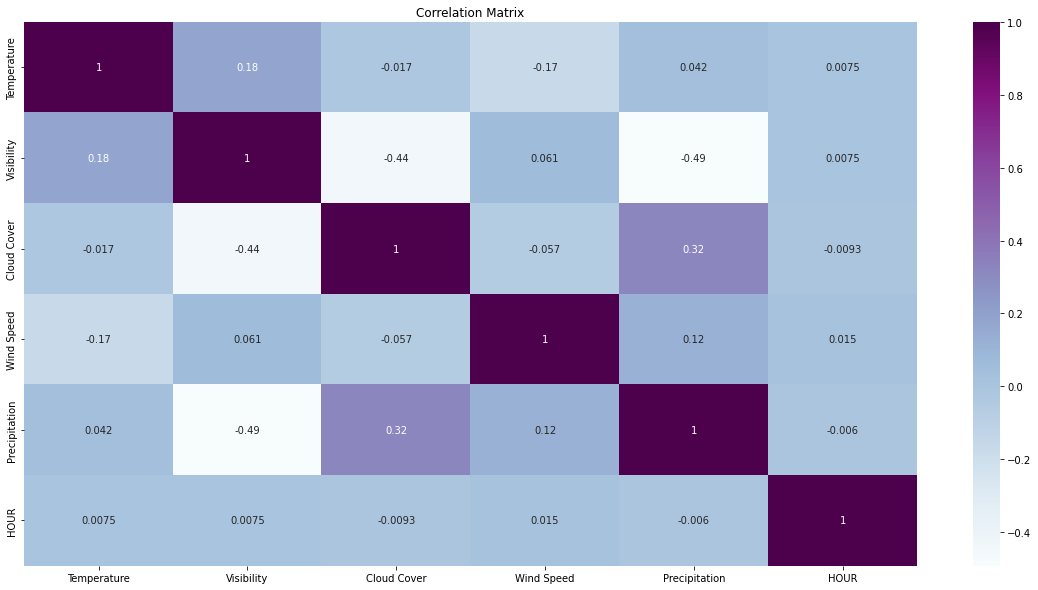

In [12]:
# view correlation betwen features 
heat_corr = df_features.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(heat_corr, annot=True, cmap='BuPu')
plt.title("Correlation Matrix")
plt.show()

In [13]:
# check for null values
df_features.isnull().sum()

Temperature      0
Visibility       0
Cloud Cover      0
Wind Speed       0
Precipitation    0
Conditions       0
MONTH            0
HOUR             0
WEEKDAY          0
dtype: int64

In [14]:
# view feature statistics 
df_features.describe()

,Temperature,Visibility,Cloud Cover,Wind Speed,Precipitation,HOUR
count,17152.000000,17152.000000,17152.000000,17152.000000,17152.000000,17152.000000
mean,61.239267,9.482923,62.914949,15.124026,0.115518,11.760028
std,16.498757,0.931812,22.642289,4.942742,0.294157,7.477634
min,15.000000,1.900000,0.000000,5.600000,0.000000,0.000000
25%,47.300000,9.600000,48.000000,11.500000,0.000000,4.000000
50%,63.600000,9.900000,64.600000,14.200000,0.000000,13.000000
75%,76.100000,9.900000,80.400000,18.000000,0.060000,18.000000
max,89.900000,9.900000,100.000000,43.000000,2.800000,23.000000


In [15]:
# create dummy variables for categorical data
df_features = pd.get_dummies(df_features)
df_features.columns

Index(['Temperature', 'Visibility', 'Cloud Cover', 'Wind Speed',
       'Precipitation', 'HOUR', 'Conditions_Clear', 'Conditions_Overcast',
       'Conditions_Partially cloudy', 'Conditions_Rain',
       'Conditions_Rain, Overcast', 'Conditions_Rain, Partially cloudy',
       'Conditions_Snow', 'Conditions_Snow, Overcast',
       'Conditions_Snow, Partially cloudy', 'MONTH_Apr', 'MONTH_Aug',
       'MONTH_Dec', 'MONTH_Feb', 'MONTH_Jan', 'MONTH_Jul', 'MONTH_Jun',
       'MONTH_Mar', 'MONTH_May', 'MONTH_Nov', 'MONTH_Oct', 'MONTH_Sep',
       'WEEKDAY_Fri', 'WEEKDAY_Mon', 'WEEKDAY_Sat', 'WEEKDAY_Sun',
       'WEEKDAY_Thu', 'WEEKDAY_Tue', 'WEEKDAY_Wed'],
      dtype='object')

In [16]:
# create dummy variables for hour variable
hour_dummy = pd.get_dummies(df_features['HOUR'])
hour_dummy.columns = ['Hour_0','Hour_1','Hour_2','Hour_3','Hour_4','Hour_5','Hour_6','Hour_7','Hour_8','Hour_9',
                 'Hour_10','Hour_11','Hour_12','Hour_13','Hour_14','Hour_15','Hour_16','Hour_17','Hour_18',
                 'Hour_19','Hour_20','Hour_21','Hour_22','Hour_23']
df_features = pd.concat([df_features, hour_dummy] , axis = 1)

In [17]:
# drop hour "HOUR" column from features df
df_features.drop(columns='HOUR', inplace=True)
df_features.columns

Index(['Temperature', 'Visibility', 'Cloud Cover', 'Wind Speed',
       'Precipitation', 'Conditions_Clear', 'Conditions_Overcast',
       'Conditions_Partially cloudy', 'Conditions_Rain',
       'Conditions_Rain, Overcast', 'Conditions_Rain, Partially cloudy',
       'Conditions_Snow', 'Conditions_Snow, Overcast',
       'Conditions_Snow, Partially cloudy', 'MONTH_Apr', 'MONTH_Aug',
       'MONTH_Dec', 'MONTH_Feb', 'MONTH_Jan', 'MONTH_Jul', 'MONTH_Jun',
       'MONTH_Mar', 'MONTH_May', 'MONTH_Nov', 'MONTH_Oct', 'MONTH_Sep',
       'WEEKDAY_Fri', 'WEEKDAY_Mon', 'WEEKDAY_Sat', 'WEEKDAY_Sun',
       'WEEKDAY_Thu', 'WEEKDAY_Tue', 'WEEKDAY_Wed', 'Hour_0', 'Hour_1',
       'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8',
       'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14',
       'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20',
       'Hour_21', 'Hour_22', 'Hour_23'],
      dtype='object')

In [18]:
# check the shapes of features df and label df 
print(df_features.shape)
print(label_df.shape)

(17152, 57)
(17152, 4)


## Injury Severity Classification

In [19]:
# create X and y variables then split into train and test
y = label_df['Severity']
X = df_features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Random Forest (Unbalanaced)

In [20]:
# implement random forest without balanced data or optimization
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

In [21]:
# view results 
print(metrics.classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      4870
         1.0       0.10      0.03      0.05       251
         2.0       0.00      0.00      0.00        25

    accuracy                           0.93      5146
   macro avg       0.35      0.34      0.34      5146
weighted avg       0.90      0.93      0.92      5146



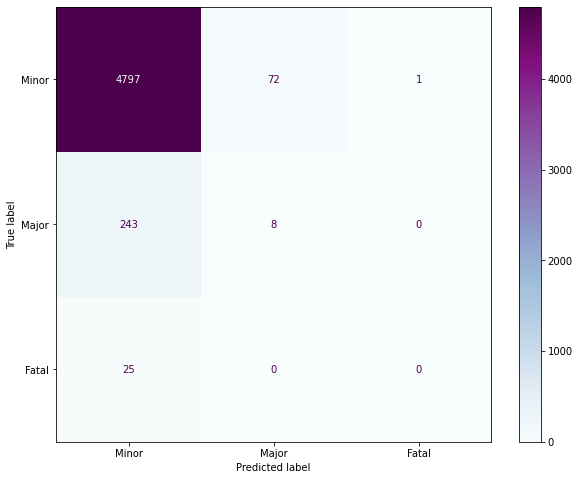

In [22]:
# view confusion matrix 
label = ['Minor', 'Major', 'Fatal']
cm_rf = metrics.confusion_matrix(y_test, y_pred_rf)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_rf, display_labels=label)
cm_display.plot(cmap='BuPu')
plt.show()

In [23]:
# create function to get average roc and auc score for each class
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        other_class = [x for x in unique_class if x != per_class]

        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [24]:
# view roc and auc score
roc_auc_rf = roc_auc_score_multiclass(y_test, y_pred_rf)
roc_auc_rf

{0.0: 0.5069978870934143, 1.0: 0.5085818116705803, 2.0: 0.49990236281976175}

### XGBoost (Unbalanced)

In [25]:
# implement XGBoost without balanced data or optimization
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [26]:
# view results
print(metrics.classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      4870
         1.0       0.00      0.00      0.00       251
         2.0       0.00      0.00      0.00        25

    accuracy                           0.95      5146
   macro avg       0.32      0.33      0.32      5146
weighted avg       0.90      0.95      0.92      5146



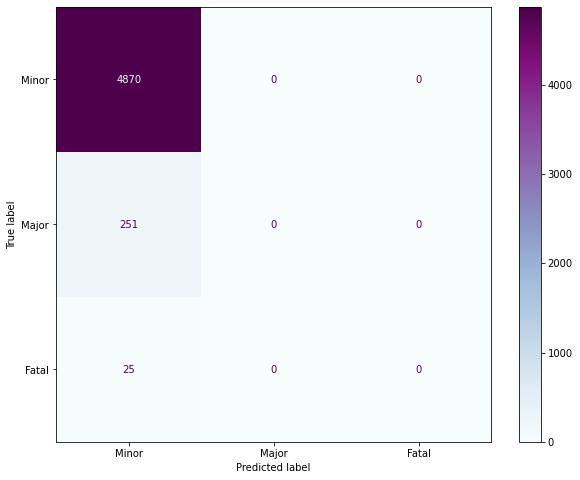

In [27]:
# view confusion matrix
cm_xgb = metrics.confusion_matrix(y_test, y_pred_xgb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_xgb, display_labels=label)
cm_display.plot(cmap='BuPu')
plt.show()

In [28]:
# view roc and auc score
roc_auc_xgb = roc_auc_score_multiclass(y_test, y_pred_xgb)
roc_auc_xgb

{0.0: 0.5, 1.0: 0.5, 2.0: 0.5}

## SMOTE - Balance the data

In [29]:
# implement SMOTE to balance the data
print('After OverSampling, the shape of X: {}'.format(X.shape))
print('After OverSampling, the shape of y: {} \n'.format(y.shape))

print("Before OverSampling, counts of label 'Minor': {}".format(sum(y == 0)))
print("Before OverSampling, counts of label 'Major': {} \n".format(sum(y == 1)))
print("Before OverSampling, counts of label 'Fatal': {} \n".format(sum(y == 2)))

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

print('After OverSampling, the shape of X: {}'.format(X_res.shape))
print('After OverSampling, the shape of y: {} \n'.format(y_res.shape))

print("After OverSampling, counts of label 'Minor': {}".format(sum(y_res == 0)))
print("After OverSampling, counts of label 'Major': {} \n".format(sum(y_res == 1)))
print("After OverSampling, counts of label 'Fatal': {} \n".format(sum(y_res == 2)))

After OverSampling, the shape of X: (17152, 57)
After OverSampling, the shape of y: (17152,) 

Before OverSampling, counts of label 'Minor': 16224
Before OverSampling, counts of label 'Major': 864 

Before OverSampling, counts of label 'Fatal': 64 

After OverSampling, the shape of X: (48672, 57)
After OverSampling, the shape of y: (48672,) 

After OverSampling, counts of label 'Minor': 16224
After OverSampling, counts of label 'Major': 16224 

After OverSampling, counts of label 'Fatal': 16224 



In [30]:
# split the balanced data
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

### Random Forest (Balanced)

In [31]:
# implement random forest with balanced data, but without optimization
rf1 = RandomForestClassifier(n_estimators=100, random_state=42)

rf1.fit(X_train_res, y_train_res)

y_pred_rf1 = rf.predict(X_test_res)

In [32]:
# view results
print(metrics.classification_report(y_test_res, y_pred_rf1))

              precision    recall  f1-score   support

         0.0       0.34      0.99      0.50      4899
         1.0       0.82      0.03      0.06      4847
         2.0       0.89      0.00      0.00      4856

    accuracy                           0.34     14602
   macro avg       0.68      0.34      0.19     14602
weighted avg       0.68      0.34      0.19     14602



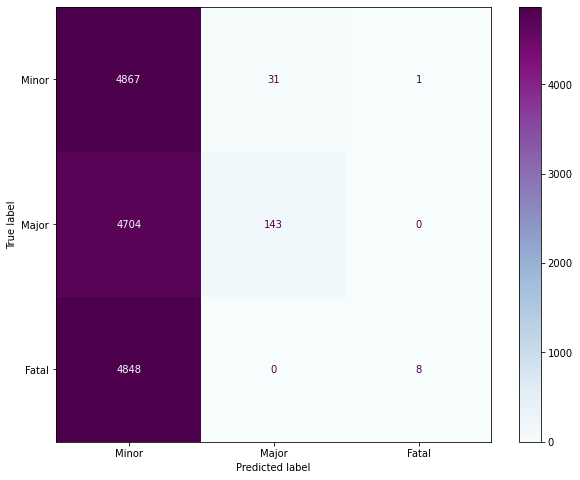

In [33]:
# view confusion matrix
cm_rf1 = metrics.confusion_matrix(y_test_res, y_pred_rf1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_rf1, display_labels=label)
cm_display.plot(cmap='BuPu')
plt.show()

In [34]:
# view roc and auc score
roc_auc_rf1 = roc_auc_score_multiclass(y_test_res, y_pred_rf1)
roc_auc_rf1

{0.0: 0.5045151259818108, 1.0: 0.5131624638595031, 2.0: 0.5007724201302879}

### XGBoost (Balanced)

In [35]:
# implement XGBoost with balanced data, but without optimization
xgb1 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb1.fit(X_train_res, y_train_res)
y_pred_xgb1 = xgb1.predict(X_test_res)

In [36]:
# view results
print(metrics.classification_report(y_test_res, y_pred_xgb1))

              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91      4899
         1.0       0.83      0.58      0.68      4847
         2.0       0.77      0.88      0.82      4856

    accuracy                           0.81     14602
   macro avg       0.81      0.81      0.80     14602
weighted avg       0.81      0.81      0.80     14602



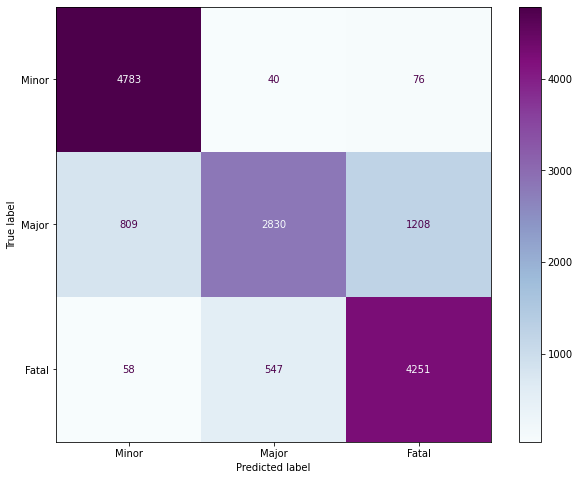

In [37]:
# view confusion matrix
cm_xgb1 = metrics.confusion_matrix(y_test_res, y_pred_xgb1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_xgb1, display_labels=label)
cm_display.plot(cmap='BuPu')
plt.show()

In [38]:
# view roc and auc score
roc_auc_xgb1 = roc_auc_score_multiclass(y_test_res, y_pred_xgb1)
roc_auc_xgb1

{0.0: 0.9434839451025947, 1.0: 0.7618460197259092, 2.0: 0.871832752067253}

### Random Forest CV Grid Search

In [39]:
# create CV Grid parameter for random forest
param_rf = { 
    'n_estimators': [100,200,400,600,800],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth'   : [4,6,8],
    'criterion'   :['gini', 'entropy']
}

In [40]:
# perform CV Grid with the provided parameters
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_rf, cv= 5)
CV_rfc.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 400, 600, 800]})

In [41]:
# view best parameters
print(CV_rfc.best_params_)

{'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 400}


In [42]:
# re-run random forest with balanced data and optimal parameters
rf2 = RandomForestClassifier(n_estimators=400, 
                              criterion='gini', 
                              max_features='log2',
                              max_depth=8,
                              random_state=42)

rf2.fit(X_train_res, y_train_res)

y_pred_rf2 = rf2.predict(X_test_res)

In [43]:
# view results
print(metrics.classification_report(y_test_res, y_pred_rf2))

              precision    recall  f1-score   support

         0.0       0.78      0.99      0.87      4899
         1.0       0.77      0.37      0.50      4847
         2.0       0.69      0.86      0.77      4856

    accuracy                           0.74     14602
   macro avg       0.75      0.74      0.71     14602
weighted avg       0.75      0.74      0.71     14602



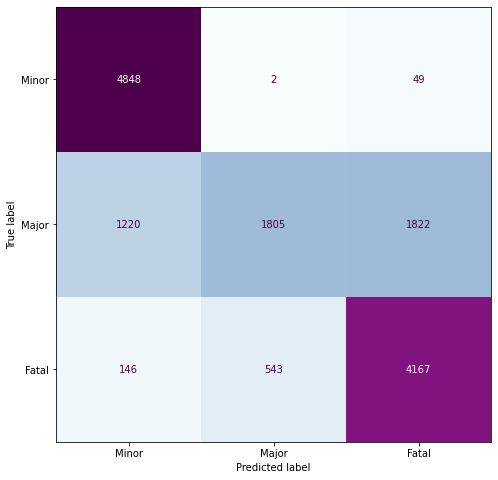

In [44]:
# view confusion matrix
cm_rf2 = metrics.confusion_matrix(y_test_res, y_pred_rf2)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_rf2, display_labels=label)
cm_display.plot(cmap='BuPu', colorbar=False)
plt.show()

In [45]:
# view roc and auc scores
roc_auc_rf2 = roc_auc_score_multiclass(y_test_res, y_pred_rf2)
roc_auc_rf2

{0.0: 0.9244042552479808, 1.0: 0.6582632554105394, 2.0: 0.8330687392217008}

### XGBoost CV Grid Search

In [46]:
# create CV Grid parameter for random forest
param_grid_xgb = {'n_estimators': [100, 200, 400],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.20],
    }

In [47]:
# run CV Grid with provided parameters
CV_xgb = GridSearchCV(estimator=XGBClassifier(random_state=42), param_grid=param_grid_xgb, cv= 5)
CV_xgb.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, estimator=XGBClassifier(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [100, 200, 400]})

In [48]:
# view best parameters
print(CV_xgb.best_params_)

{'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 400}


In [49]:
# re-run XGBoost with balanced data and optimal parameters
xgb2 = XGBClassifier(use_label_encoder=False, learning_rate= 0.2, 
                     max_depth= 8, n_estimators= 400, eval_metric='mlogloss', random_state=42)
xgb2.fit(X_train_res, y_train_res)
y_pred_xgb2 = xgb2.predict(X_test_res)

In [50]:
# view results
print(metrics.classification_report(y_test_res, y_pred_xgb2))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      4899
         1.0       0.98      0.94      0.96      4847
         2.0       0.98      0.99      0.99      4856

    accuracy                           0.97     14602
   macro avg       0.97      0.97      0.97     14602
weighted avg       0.97      0.97      0.97     14602



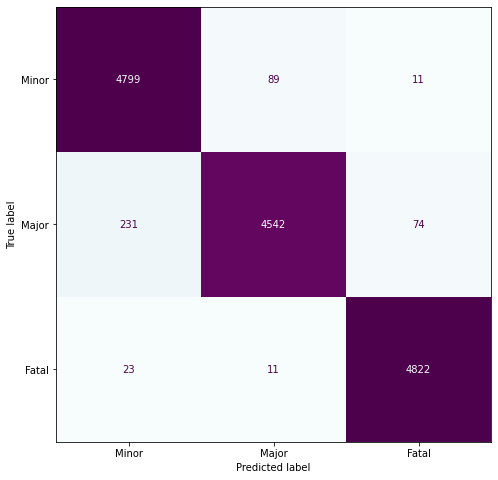

In [51]:
# view confusion matrix
cm_xgb2 = metrics.confusion_matrix(y_test_res, y_pred_xgb2)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_xgb2, display_labels=label)
cm_display.plot(cmap='BuPu', colorbar=False)
plt.show()

In [52]:
# XGBoost roc auc score
roc_auc_xgb2 = roc_auc_score_multiclass(y_test_res, y_pred_xgb2)
roc_auc_xgb2

{0.0: 0.9767051000339811, 1.0: 0.9634116629022355, 2.0: 0.9921384128866623}

### Random Forest Feature Importance

In [53]:
# create feature importance for random forest 
importances_rf = rf2.feature_importances_

In [54]:
# create feature importance df
imp = pd.DataFrame(importances_rf)
imp['Features'] = df_features.columns
imp.rename(columns={0:'Importance'}, inplace=True)
imp = imp.sort_values(by='Importance', ascending=False)
imp = imp[['Features', 'Importance']]
imp

,Features,Importance
26,WEEKDAY_Fri,0.080155
30,WEEKDAY_Thu,0.079336
31,WEEKDAY_Tue,0.074989
32,WEEKDAY_Wed,0.073439
0,Temperature,0.064570
28,WEEKDAY_Sat,0.054298
29,WEEKDAY_Sun,0.044597
27,WEEKDAY_Mon,0.040603
23,MONTH_Nov,0.040130
2,Cloud Cover,0.031081


In [55]:
# display the feature importance
fig = px.bar(imp, x='Importance', y='Features', title='Feature Importance', color ='Features', orientation='h')
fig.show()

### XGBoost Feature Importance

In [56]:
# create feature importance for XGBoost
importances_xgb = xgb2.feature_importances_

In [57]:
# create feature importance df
imp2 = pd.DataFrame(importances_xgb)
imp2['Features'] = df_features.columns
imp2.rename(columns={0:'Importance'}, inplace=True)
imp2 = imp2.sort_values(by='Importance', ascending=False)
imp2 = imp2[['Features', 'Importance']]
imp2

,Features,Importance
27,WEEKDAY_Mon,0.076100
29,WEEKDAY_Sun,0.051310
28,WEEKDAY_Sat,0.045421
26,WEEKDAY_Fri,0.044488
32,WEEKDAY_Wed,0.043803
31,WEEKDAY_Tue,0.040747
30,WEEKDAY_Thu,0.035321
47,Hour_14,0.032637
52,Hour_19,0.023948
54,Hour_21,0.021138


In [58]:
# display the feature importance
fig = px.bar(imp2, x='Importance', y='Features', title='Feature Importance', color ='Features', orientation='h')
fig.show()

### Display Random Forest tree

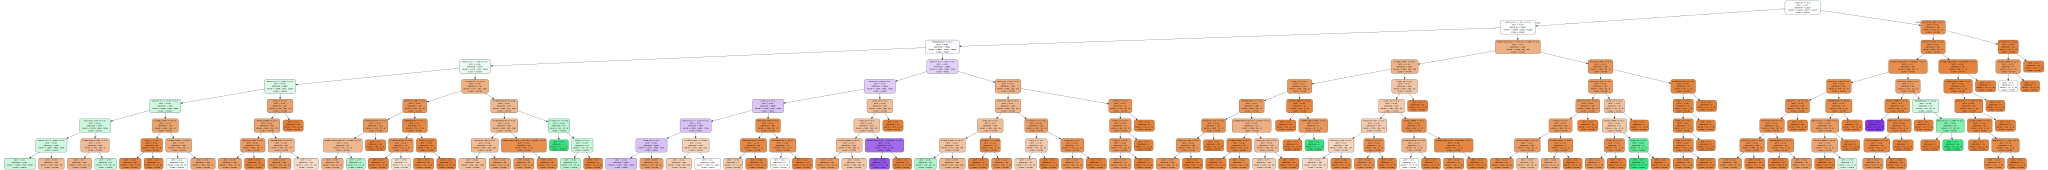

In [59]:
# view single random forest tree
tree = export_graphviz(rf2.estimators_[0], 
                out_file= None,
                feature_names = X_train.columns,
                class_names = label,
                rounded = True, proportion = False, 
                precision = 2, filled = True)
graphviz.Source(tree)